In [25]:
import os
import torch
import torchvision
from torch import nn
from d2l import torch as d2l
from torch.nn import functional as F
from torch.utils import data
import torchvision.datasets as datasets 
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from torchvision import transforms
from PIL import Image

In [2]:
data_dir = '..\\data\\kaggle_dog_tiny'

In [3]:
def reorg_dog_data(data_dir, valid_ratio):
    labels = d2l.read_csv_labels(os.path.join(data_dir, 'labels.csv'))
    d2l.reorg_train_valid(data_dir, labels, valid_ratio)
    d2l.reorg_test(data_dir)


batch_size = 32
valid_ratio = 0.1
reorg_dog_data(data_dir, valid_ratio)

In [4]:
transform_train = torchvision.transforms.Compose([
    
    torchvision.transforms.RandomResizedCrop(224, scale=(0.08, 1.0),
                                             ratio=(3.0/4.0, 4.0/3.0)),
    torchvision.transforms.RandomHorizontalFlip(),

    torchvision.transforms.ColorJitter(brightness=0.4,
                                       contrast=0.4,
                                       saturation=0.4),
   
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Normalize([0.485, 0.456, 0.406],
                                     [0.229, 0.224, 0.225])])

In [5]:
transform_test = torchvision.transforms.Compose([
    torchvision.transforms.Resize([224,224]),
    #torchvision.transforms.CenterCrop(224),
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Normalize([0.485, 0.456, 0.406],
                                     [0.229, 0.224, 0.225])])

In [6]:
train_ds, train_valid_ds = [torchvision.datasets.ImageFolder(
    os.path.join(data_dir, 'train_valid_test', folder),
    transform=transform_train) for folder in ['train', 'train_valid']]

valid_ds, test_ds = [torchvision.datasets.ImageFolder(
    os.path.join(data_dir, 'train_valid_test', folder),
    transform=transform_test) for folder in ['valid', 'test']]

In [8]:
def AccCount(net, test_loader): 
    device = d2l.try_gpu()
    net.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for data in test_loader:
            X,y = data
            if isinstance(X, list):
                X = [x.to(device) for x in X]
            else:
                X = X.to(device)
            y = y.to(device)
            preds = net(X).argmax(axis=1)
            for i in range(len(y)):
                if y[i].item() == preds[i].item():
                    correct += 1
            total += len(y)
           
    return correct/total,correct,total

def trainCNN(net, train_loader, test_loader, num_epochs, lr, device):
    #xavier initialization 
    def init_weights(m):
        if type(m) == nn.Linear or type(m) == nn.Conv2d:
            nn.init.xavier_uniform_(m.weight)
    #net.apply(init_weights)
    
    #prompt message for device
    print('training on', device)
    net.to(device)
    
    #define optimizer and loss function
    optimizer = torch.optim.SGD(net.parameters(), lr=lr)
    loss = nn.CrossEntropyLoss()
    train_l = []
    train_acc = []
    #training 
    for epoch in range(1,num_epochs+1):
        net.train()
        for data in (train_loader):
            X,y = data
            y = y.type(torch.LongTensor)
            optimizer.zero_grad()
            X, y = X.to(device), y.to(device)
            y_hat = net(X)
            y_hat = y_hat.to(device)
        
            l = loss(y_hat, y)
            l.backward()
            optimizer.step()
        acc,correct,total= AccCount(net, test_loader)
        train_acc.append(acc)
        
        ls = l.cpu()
        train_l.append(float(ls))
        
        #print(f'Epoch {epoch}, Loss {float(l):f}')
        print(f'Epoch {epoch}, Loss {float(l):f}, Accuracy {correct}/{total}:{acc*100:f}%')
    
    
  
    plt.plot(list(range(1,num_epochs+1)), train_l,label = 'loss')
    plt.plot(list(range(1,num_epochs+1)), train_acc,label = 'Accuracy')
    plt.title('Train Loss and Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Loss and Accuracy')
    plt.legend()
    plt.show()

In [10]:
batch_size = 64
train_iter, train_valid_iter = [torch.utils.data.DataLoader(
    dataset, batch_size, shuffle=True, drop_last=True)
    for dataset in (train_ds, train_valid_ds)]

valid_iter = torch.utils.data.DataLoader(valid_ds, batch_size, shuffle=False,
                                         drop_last=True)

test_iter = torch.utils.data.DataLoader(test_ds, batch_size, shuffle=False,
                                        drop_last=False)

training on cuda:0
Epoch 1, Loss 4.348225, Accuracy 122/960:12.708333%
Epoch 2, Loss 3.895286, Accuracy 300/960:31.250000%
Epoch 3, Loss 3.283279, Accuracy 397/960:41.354167%
Epoch 4, Loss 2.727220, Accuracy 446/960:46.458333%
Epoch 5, Loss 2.293172, Accuracy 500/960:52.083333%
Epoch 6, Loss 2.019619, Accuracy 563/960:58.645833%
Epoch 7, Loss 2.004916, Accuracy 608/960:63.333333%
Epoch 8, Loss 1.813798, Accuracy 668/960:69.583333%
Epoch 9, Loss 1.642089, Accuracy 651/960:67.812500%
Epoch 10, Loss 1.497662, Accuracy 682/960:71.041667%
Epoch 11, Loss 1.480724, Accuracy 692/960:72.083333%
Epoch 12, Loss 1.562425, Accuracy 716/960:74.583333%
Epoch 13, Loss 1.146878, Accuracy 698/960:72.708333%
Epoch 14, Loss 1.129112, Accuracy 722/960:75.208333%
Epoch 15, Loss 0.982335, Accuracy 746/960:77.708333%
Epoch 16, Loss 1.068797, Accuracy 744/960:77.500000%
Epoch 17, Loss 1.361408, Accuracy 750/960:78.125000%
Epoch 18, Loss 1.007697, Accuracy 733/960:76.354167%
Epoch 19, Loss 0.758610, Accuracy 74

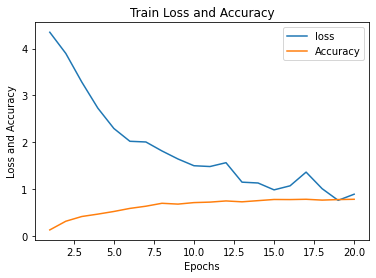

In [12]:
def get_net(devices):
    finetune_net = nn.Sequential()
    finetune_net.features = torchvision.models.resnet34(pretrained=True)
    finetune_net.output_new = nn.Sequential(nn.Linear(1000, 256),
                                            nn.ReLU(),
                                            nn.Linear(256, 120))
    
    finetune_net = finetune_net.to(devices)

    for param in finetune_net.features.parameters():
        param.requires_grad = False
    return finetune_net
lr, num_epochs = 0.03, 20
myresnet = get_net(d2l.try_gpu())
trainCNN(myresnet, train_iter,train_valid_iter, num_epochs, lr, d2l.try_gpu())

Breed is : pembroke


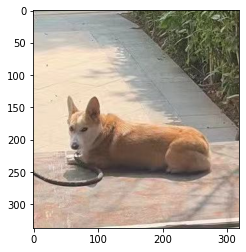

Breed is : pembroke


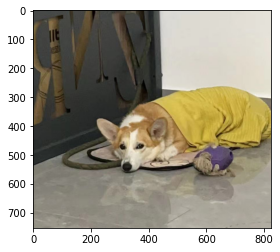

In [16]:




def readimg(net,path):
    labels = d2l.read_csv_labels(os.path.join(data_dir, 'labels.csv'))
    lb = list(labels.values())
    lb =  sorted([*set(lb)])
    #print(lb)
    net.eval()
    device = d2l.try_gpu()
    img = Image.open(path).convert('RGB')

    
    
    testimg = transform_test(img)
    
    
    
    
    output = torch.rand(size=(1, 3, 224, 224), dtype=torch.float32)
    if isinstance(output, list):
        output = [x.to(device) for x in output]
    else:
        output = output.to(device)
    output[0] = testimg
    pred = net(output).argmax(axis=1).item()
    
    print(f'Breed is : {lb[pred]}')
    output=output.cpu()
    plt.imshow(img)
    plt.show()
    
    
readimg(myresnet,'xiameng.jpg')
readimg(myresnet,'xiameng2.jpg')

In [17]:
torch.save(myresnet.state_dict(), 'modelsave')

Breed is : pembroke


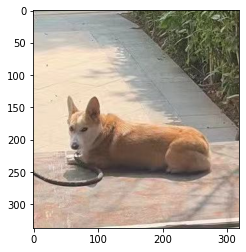

Breed is : pembroke


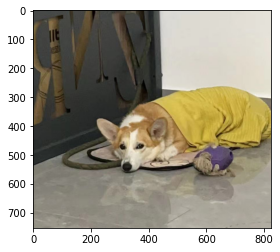

In [26]:
model = get_net(d2l.try_gpu())
model.load_state_dict(torch.load('modelsave'))
model.eval()
#save and load
readimg(model,'xiameng.jpg')
readimg(model,'xiameng2.jpg')